In [2]:
#manipulate/organize data
import pandas as pd
import numpy as np
#preprocess data
import unicodedata as ud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [1439]:
df_seloger = pd.read_csv("data_sample_1584.csv")

In [1454]:
print(df_seloger.columns.tolist())

['href', 'title']


In [5]:
print(len(df_seloger))

1584


In [6]:
test_str = "Appartement à vendre - Paris 16ème - 4 900 000 € - 7 pièces, 5 chambres, 290,7 m², Étage 4/7"

In [7]:
locs = {
    "Paris",
    "Boulogne-Billancourt","Neuilly-sur-Seine","Levallois-Perret","Clichy","Clichy-la-Garenne",
    "Courbevoie","La Garenne-Colombes","Asnieres-sur-Seine","Colombes","Puteaux","Suresnes",
    "Nanterre","Rueil-Malmaison","Saint-Cloud","Sevres","Meudon","Issy-les-Moulineaux","Vanves",
    "Malakoff","Montrouge","Chatillon","Clamart","Chatenay-Malabry","Bagneux",
    "Saint-Ouen-sur-Seine","Saint-Denis","Aubervilliers","Pantin","Montreuil","Bagnolet",
    "Les Lilas","Le Pre-Saint-Gervais","Noisy-le-Sec","Romainville","Bobigny","Drancy","La Courneuve",
    "Ivry-sur-Seine","Charenton-le-Pont","Saint-Mande","Vincennes","Maisons-Alfort","Alfortville",
    "Le Kremlin-Bicetre","Gentilly","Villejuif","Arcueil","Cachan","Nogent-sur-Marne",
    "Fontenay-sous-Bois","Le Perreux-sur-Marne","Joinville-le-Pont","Saint-Maur-des-Fosses"
}

STEM_MAP = {
    "BOULOGN": "Boulogne-Billancourt",
    "BILLANCOURT": "Boulogne-Billancourt",
    "BOULOGN BILLANCOURT": "Boulogne-Billancourt",
    "NEUILLY": "Neuilly-sur-Seine",
    "NEUILLY SEIN": "Neuilly-sur-Seine",
    "LEVALLOIS PERRET": "Levallois-Perret",
    "CLICHY": "Clichy",
    "CLICHY GAREN": "Clichy-la-Garenne",
    "SAINT CLOUD": "Saint-Cloud",
    "CLOUD": "Saint-Cloud",
    "PUTEAU": "Puteaux",
    "SURESN": "Suresnes",
    "ISSY": "Issy-les-Moulineaux",
    "ISSY MOULINEAU": "Issy-les-Moulineaux",
    "MOULINEAU": "Issy-les-Moulineaux",
    "MONTROUG": "Montrouge",
    "LE LIL": "Les Lilas",
    "AUBERVILLI": "Aubervilliers",
    "SAINT OUEN SEIN": "Saint-Ouen-sur-Seine",
    "OUEN": "Saint-Ouen-sur-Seine",
    "CHARENTON": "Charenton-le-Pont",
    "VANV": "Vanves",
    "MONTREUIL": "Montreuil",
    "PANTIN": "Pantin",
    "PARIS": "Paris",
}

In [8]:
def remove_accents(text: str) -> str:
    #replace diacritics
    text = (text.replace("œ", "oe").replace("Œ", "OE")
           .replace("æ", "ae").replace("Æ", "AE"))
    #decompose form 'è' -> 'e' + '`'
    text = ud.normalize("NFD",text)
    #remove accents like '`','^',...
    text = "".join([char for char in text if ud.category(char) != "Mn"])
    #recompose 
    text = ud.normalize("NFC",text)
    return text
print(remove_accents(test_str))

Appartement a vendre - Paris 16eme - 4 900 000 € - 7 pieces, 5 chambres, 290,7 m², Etage 4/7


In [869]:
def preprocess_french_nltk(text: str) -> str:
    text = remove_accents(text)
    stemmer = SnowballStemmer("french")
    stop_fr = set(stopwords.words("french"))
    #print(stop_fr)
    tokens = re.findall(r"[A-Za-zÀ-ÖØ-öø-ÿ\d/(m2|m²).]+", text)
    tokens = [t for t in tokens if t not in stop_fr]
    #print(tokens)
    stems  = [stemmer.stem(t) for t in tokens]
    #print(stems)
    return (" ".join(stems)).upper()
print(preprocess_french_nltk("Maison à vendre - Paris 15ème - 2 280 000 € - 6 pièces, 4 chambres, 140,1 m², 38 m² de terrain"))
print(preprocess_french_nltk("DISPONIBLE IMMEDIATEMENT"))

MAISON A VENDR PARIS 15EM 2 280 000 6 PIEC 4 CHAMBR 140 1 M² 38 M² TERRAIN
DISPONIBL IMMEDIAT


In [71]:
def extract_tokens(text : str = ""):
    #convert , of float num to .
    text = re.sub(r"(?<=\d),(?=\d)",".",text)
    #convert "-" to " "
    text = re.sub(r'(?<=[^\W\d_])-(?=[^\W\d_])', ' ', text, flags=re.UNICODE)
    tkns = [tkn.strip() for tkn in re.split("[-,]",text)]
    return tkns

In [27]:
def convert_2price(price_str : str = None)->str:
    try :
        price_str = "".join([chr for chr in price_str if chr.isdigit()])
        return float(price_str)
    except Exception :
        return None

In [12]:
def extract_price(tkns : list = None):
    if not tkns :
        return None
    EUR_PATTERN = re.compile(r"(€|\b(?:eur|euro(?:s)?)\b)", re.IGNORECASE)
    GBP_PATTERN = re.compile(r"(£|\b(?:gbp|pound(?:s)?)\b)", re.IGNORECASE)
    USD_PATTERN = re.compile(r"(\$|\b(?:usd|dollar(?:s)?)\b)", re.IGNORECASE)
    m_tkns = []
    prices = []
    if not tkns :
        raise ValueError("elements = None")
    for tkn in tkns :
        if bool(EUR_PATTERN.search(tkn)):
            prices.append([tkn,"EUR"])
        elif bool(GBP_PATTERN.search(tkn)):
            prices.append([tkn,"GBP"])
        elif bool(USD_PATTERN.search(tkn)):
            prices.append([tkn,"USD"])
        else :
            m_tkns.append(tkn)
    if len(prices) != 1:
        raise ValueError("More than 1 or no price for this property")
    return [m_tkns,prices[0]]

In [13]:
"""
def extract_elementsssssss(elements : list =None, tobe_extracted : set =None):
    if not elements or not tobe_extracted:
        return None
    filtered_elements = []
    extract = []
    for element in elements :
        if element in tobe_extracted :
            extract.append(element)
        else :
            filtered_elements.append(element)
    if len(extract) == 0 :
        return elements
    return [filtered_elements,extract]
"""

'\ndef extract_elementsssssss(elements : list =None, tobe_extracted : set =None):\n    if not elements or not tobe_extracted:\n        return None\n    filtered_elements = []\n    extract = []\n    for element in elements :\n        if element in tobe_extracted :\n            extract.append(element)\n        else :\n            filtered_elements.append(element)\n    if len(extract) == 0 :\n        return elements\n    return [filtered_elements,extract]\n'

In [14]:
"""
How are we going to vectorize these infos ?
numerical dimensions (principal):
- PIEC : number of pieces
- CHAMBR : number of chambers
- AREA : surface area 
- PRICE 
- (optional) FLR : floor
- (optional) T_FLR : total number of floors

categorical :
- appartment,maison,.. (categorize)
- Arrondissement (to be one hot encoded) or to categorize (easier + probably more accurate)
"""

'\nHow are we going to vectorize these infos ?\nnumerical dimensions (principal):\n- PIEC : number of pieces\n- CHAMBR : number of chambers\n- AREA : surface area \n- PRICE \n- (optional) FLR : floor\n- (optional) T_FLR : total number of floors\n\ncategorical :\n- appartment,maison,.. (categorize)\n- Arrondissement (to be one hot encoded) or to categorize (easier + probably more accurate)\n'

In [691]:
#first lets see how many type of form of data are there.

In [15]:
def normalize_token(t):
    t = t.upper().strip()
    #identify patterns to remove, goal is to reduce similar structures (variate by these patterns) into one unique structure
    NUM_PATTERN = re.compile(r'\d+(?:[.,]\d+)?')  # 5, 12, 83.5, 1/7 (we’ll handle '/' separately)
    ORDINAL_PATTERN = re.compile(r'\b\d+(?:ER|EM)\b', flags=re.IGNORECASE)  # 1ER, 12EM
    if "ETAG" in t :
        return "ETAG"
    if 'RDC' in t:             # e.g., "RDC/1", "RDC"
        return 'RDC'
    if 'TERRAIN' in t:
        return 'TERRAIN'       # keep presence of land info
    if 'SURFAC' in t:
        return 'SURFAC'       # unify SURFAC VENT variants a bit (optional)

    # Remove ordinals like 1ER / 12EM and plain numbers/decimals
    t = ORDINAL_PATTERN.sub('', t)
    t = t.replace('/', ' ')            # split fractions like "1/7"
    t = NUM_PATTERN.sub('', t)

    # Collapse whitespace
    t = re.sub(r'\s+', ' ', t).strip()

    return t

In [16]:
def normalize_sequence(seq) -> tuple:
    n_tkns = []
    for tkn in seq :
        if str(tkn).strip() :
            n_tkn = normalize_token(tkn)
            if n_tkn:
                n_tkns.append(n_tkn)
    return tuple(n_tkns)

In [17]:
def get_variegated_sequences(seqs):
    return { normalize_sequence(seq) for seq in seqs }

In [537]:
#uncomplete.
def get_processed(series):
    #df = pd.DataFrame(columns=["_","PRICE","UNIT-PRICE"])
    lefts = []
    prices =[]
    price_units = []
    raws = []
    for i in range(len(series)):
        left,(price_str,price_unit)=extract_price(extract_tokens(series.iloc[i]))
        left = list(map(preprocess_french_nltk,left))
        price = convert_2price(price_str)
        if price == None :
            print(price_str)
        if price > 1000 :# add threshold to prevent false pricing
            lefts.append(left)
            prices.append(price)
            price_units.append(price_unit)
            raws.append(series.iloc[i])
        #print(f"ERROR {Exception} at : ",series.iloc[i])
        #left,categories    
    _#,df["CATS"] = series.apply(lambda x:extract_elements(x))
    return (pd.DataFrame({"RAW" : raws,"TAG":lefts,"PRICE":prices,"PRICE_UNIT":price_units}))

In [527]:
#rlsts for real estate
rlsts = df_seloger["title"].copy(deep =True)
rlsts.head()

0    Appartement à vendre - Paris 1er - 560 000 € -...
1    Appartement à vendre - Paris 12ème - 849 000 €...
2    Appartement à vendre - Paris 18ème - 1 550 000...
3    Appartement à vendre - Paris 5ème - 620 000 € ...
4    Duplex à vendre - Paris 16ème - 1 595 000 € - ...
Name: title, dtype: object

In [529]:
rlsts.iloc[0]

'Appartement à vendre - Paris 1er - 560\u202f000\xa0€ - 2 pièces, 1 chambre, 45 m², Étage 5/6'

In [531]:
p_rlsts = get_processed(series=rlsts)
variations = get_variegated_sequences(p_rlsts["TAG"].tolist())
p_rlsts.head()

,RAW,TAG,PRICE,PRICE_UNIT
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR
1,Appartement à vendre - Paris 12ème - 849 000 €...,"[APPART A VENDR, PARIS 12EM, 4 PIEC, 2 CHAMBR,...",849000.0,EUR
2,Appartement à vendre - Paris 18ème - 1 550 000...,"[APPART A VENDR, PARIS 18EM, 5 PIEC, 4 CHAMBR,...",1550000.0,EUR
3,Appartement à vendre - Paris 5ème - 620 000 € ...,"[APPART A VENDR, PARIS 5EM, 3 PIEC, 2 CHAMBR, ...",620000.0,EUR
4,Duplex à vendre - Paris 16ème - 1 595 000 € - ...,"[DUPLEX A VENDR, PARIS 16EM, 6 PIEC, 4 CHAMBR,...",1595000.0,EUR


In [539]:
tps = set(tk[0] for tk in variations)
for tp in tps :
    print(tp)

RESTAUR A VENDR
ESPAC BUREAU A VENDR
ENTREPOT A VENDR
BOUTIQU A VENDR
PROPRIET A VENDR
HOTEL PARTICULI A VENDR
LOCAL ACTIVIT A VENDR
VILL A VENDR
TERRAIN
DUPLEX A VENDR
LOCAL COMMERCIAL A VENDR
MAISON A VENDR
INSTITUT BEAUT A VENDR
APPART VIAG
APPART A VENDR
BOULANGER PATISSER A VENDR
BAR CAF A VENDR
LOFT A VENDR
MAISON VILL A VENDR
STUDIO A VENDR
GARAGE STATION A VENDR


In [541]:
s_by_tp = {}
for v in variations :
    s_by_tp[v] = v[0]
#verify if all tps present in these dict value)
print(sorted(tps) == sorted(set(list(s_by_tp.values()))))

True


In [543]:
#lets see how many variations for each type
df_vrs = pd.DataFrame([s_by_tp]).T
df_vrs.columns = ["VALUE"]
df_vrs = df_vrs.reset_index().rename(columns={"index": "KEY"})
df_vrs

,KEY,VALUE
0,"(APPART VIAG, PARIS, PIEC, CHAMBR, M², ETAG)",APPART VIAG
1,"(APPART A VENDR, NEUF, PARIS, PIEC, CHAMBR, M²...",APPART A VENDR
2,"(APPART A VENDR, CHARENTON PONT, PIEC, CHAMBR,...",APPART A VENDR
3,"(ESPAC BUREAU A VENDR, MONTROUG, M² BUREAU)",ESPAC BUREAU A VENDR
4,"(APPART A VENDR, SAINT DEN, PIEC, CHAMBR, M², ...",APPART A VENDR
...,...,...
114,"(DUPLEX A VENDR, NEUF, SAINT CLOUD, PIEC, CHAM...",DUPLEX A VENDR
115,"(ESPAC BUREAU A VENDR, NEUILLY SEIN, M² BUREAU...",ESPAC BUREAU A VENDR
116,"(HOTEL PARTICULI A VENDR, PARIS, PIEC, CHAMBR,...",HOTEL PARTICULI A VENDR
117,"(ESPAC BUREAU A VENDR, MONTREUIL, M² BUREAU)",ESPAC BUREAU A VENDR


In [545]:
def organize_df(categories,df,col):
    orgnzd_df_vrs = {}
    for cat in set(categories) :
        mask = df[col] == cat
        orgnzd_df_vrs[f"{cat}"] = df[mask].reset_index(drop=True) 
    return orgnzd_df_vrs
orgnzd_df_vrs = organize_df(tps,df_vrs,"VALUE")
print(sorted(set(orgnzd_df_vrs.keys())) == sorted(tps))

True


In [547]:
#get intersection between variations in each type to see what in common we can quantify
def get_variations_info(dict_vrs = None,save : bool = False,get_intersection : bool = True,get_union : bool = True,highlight_required : bool = True
                       ,highlights : set = None):
    """
    dict_vrs : shape = {key,value}, where key is string and value is dataframe
    """
    for k,v in sorted(dict_vrs.items()):
        #v is type df, columns = ["KEY","VALUE"], "KEY" gives sequence and "VALUE" gives type
        intersection = None
        union = None
        if get_intersection :
            intersection = set.intersection(*map(set,v["KEY"].tolist()))
        if get_union :
            union = set([t for t in v["KEY"].explode().tolist() if t not in [""," ","\n"]])
        print(f"\x1b[1m\x1b[35m>>\x1b[0m \x1b[36m[{k}]\x1b[0m - \x1b[35m[Nb variations]\x1b[0m: \x1b[33m{len(v)}\x1b[0m - "
              f"\x1b[35m[INTERSECTION]\x1b[0m: \x1b[32m{sorted(intersection) if intersection else '∅'}\x1b[0m")
        
        print("\x1b[35m[UNION]\x1b[0m:")
        for u in sorted(union):
            if highlight_required and required:
                if u in highlights :
                    print(f"  \x1b[2m•\x1b[0m \x1b[1;93m{u}\x1b[0m")
                else :
                    print(f"  \x1b[2m•\x1b[0m {u}")
            else :
                print(f"  \x1b[2m•\x1b[0m {u}")
        if save :
            v.to_csv(f"{k}_{len(v)}.csv", index=False, encoding="utf-8")
        #print("Type of value : ", type(v))
    #orgnzd_df_vrs["APPART A VENDR"]
required = {
    "M²", "SURFAC",
    "M² BUREAU", "M² ESPAC RESTAUR", "M² ESPAC STOCKAG",
    "DIVISIBL A PART M²", "DIVISIBL JUSQU A M²", "DIVISIBL M² A M²","TERRAIN"
}

get_variations_info(dict_vrs = orgnzd_df_vrs, highlights = required)

>> [APPART A VENDR] - [Nb variations]: 60 - [INTERSECTION]: ['APPART A VENDR']
[UNION]:
  • APPART A VENDR
  • AUBERVILLI
  • BOULOGN BILLANCOURT
  • CHAMBR
  • CHARENTON PONT
  • CLICHY
  • CLICHY GAREN
  • DISPONIBL MAINTEN
  • ETAG
  • ISSY MOULINEAU
  • LE LIL
  • LEVALLOIS PERRET
  • MONTREUIL
  • MONTROUG
  • M²
  • NEUF
  • NEUILLY SEIN
  • PANTIN
  • PARIS
  • PIEC
  • PUTEAU
  • RDC
  • SAINT CLOUD
  • SAINT DEN
  • SAINT OUEN SEIN
  • SURESN
  • VANV
>> [APPART VIAG] - [Nb variations]: 2 - [INTERSECTION]: ['APPART VIAG', 'CHAMBR', 'M²', 'PARIS', 'PIEC']
[UNION]:
  • APPART VIAG
  • CHAMBR
  • ETAG
  • M²
  • PARIS
  • PIEC
  • RDC
>> [BAR CAF A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BAR CAF A VENDR', 'M² ESPAC RESTAUR', 'PARIS']
[UNION]:
  • BAR CAF A VENDR
  • M² ESPAC RESTAUR
  • PARIS
>> [BOULANGER PATISSER A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BOULANGER PATISSER A VENDR', 'PARIS', 'SURFAC']
[UNION]:
  • BOULANGER PATISSER A VENDR
  • PARIS
  • SURFAC


In [549]:
"""
*lets refine the dataset by modifying or dropping some variations :
-drop : 
--No tags contains numerical surface area
--type [APPART VIAG] because we do not have age of the property owner which is crucial for predicting prices
-modify :
--drop all these tags :
    • DIVISIBL A PART M²
    • DIVISIBL JUSQU A M²
    • DIVISIBL M² A M²
--modify all ["M² ESPAC RESTAUR", "M² ESPAC STOCKAG", "M² BUREAU"] to single "M²" , assuming "SURFAC" replace "M²" and "TERRAIN" combined.
"""
def normalize_token_2(t):
    t = t.upper().strip()
    #identify patterns to remove, goal is to reduce similar structures (variate by these patterns) into one unique structure
    NUM_PATTERN = re.compile(r'\d+(?:[.,]\d+)?')  # 5, 12, 83.5, 1/7 (we’ll handle '/' separately)
    ORDINAL_PATTERN = re.compile(r'\b\d+(?:ER|EM)\b', flags=re.IGNORECASE)  # 1ER, 12EM
    if "ETAG" in t :
        return "ETAG"
    if 'RDC' in t:    
        return 'RDC'
    if 'TERRAIN' in t:
        return 'TERRAIN'
    if 'SURFAC' in t:
        return 'SURFAC'
    #remove tags
    if 'DIVISIBL A PART M²' in t or 'DIVISIBL JUSQU A M²' in t or 'DIVISIBL M² A M²' in t:
        return None
    #reduce all M² to M²
    if 'M²' in t :
        return 'M²'

    # Remove ordinals like 1ER / 12EM and plain numbers/decimals
    t = ORDINAL_PATTERN.sub('', t)
    t = t.replace('/', ' ')            # split fractions like "1/7"
    t = NUM_PATTERN.sub('', t)

    # Collapse whitespace
    t = re.sub(r'\s+', ' ', t).strip()

    return t

In [550]:
def normalize_sequence_2(seq) -> tuple:
    n_tkns = []
    for tkn in seq :
        if str(tkn).strip() :
            n_tkn = normalize_token_2(tkn)
            if n_tkn:
                n_tkns.append(n_tkn)
    if len(n_tkns) == 0 :
        return None
    return tuple(n_tkns)

In [552]:
def get_variegated_sequences_2(seqs):
    return { normalize_sequence_2(seq) for seq in seqs }

In [555]:
variations_2 = get_variegated_sequences_2(p_rlsts["TAG"].tolist())

In [556]:
tps_2 = set(tk[0] for tk in variations_2)
    
s_by_tp_2 = {}
for v in variations_2 :
    s_by_tp_2[v] = v[0]
    
df_vrs_2 = pd.DataFrame([s_by_tp_2]).T
df_vrs_2.columns = ["VALUE"]
df_vrs_2 = df_vrs_2.reset_index().rename(columns={"index": "KEY"})

orgnzd_df_vrs_2 = organize_df(tps_2,df_vrs_2,"VALUE")

get_variations_info(dict_vrs = orgnzd_df_vrs_2, highlights = required)

>> [APPART A VENDR] - [Nb variations]: 60 - [INTERSECTION]: ['APPART A VENDR']
[UNION]:
  • APPART A VENDR
  • AUBERVILLI
  • BOULOGN BILLANCOURT
  • CHAMBR
  • CHARENTON PONT
  • CLICHY
  • CLICHY GAREN
  • DISPONIBL MAINTEN
  • ETAG
  • ISSY MOULINEAU
  • LE LIL
  • LEVALLOIS PERRET
  • MONTREUIL
  • MONTROUG
  • M²
  • NEUF
  • NEUILLY SEIN
  • PANTIN
  • PARIS
  • PIEC
  • PUTEAU
  • RDC
  • SAINT CLOUD
  • SAINT DEN
  • SAINT OUEN SEIN
  • SURESN
  • VANV
>> [APPART VIAG] - [Nb variations]: 2 - [INTERSECTION]: ['APPART VIAG', 'CHAMBR', 'M²', 'PARIS', 'PIEC']
[UNION]:
  • APPART VIAG
  • CHAMBR
  • ETAG
  • M²
  • PARIS
  • PIEC
  • RDC
>> [BAR CAF A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BAR CAF A VENDR', 'M²', 'PARIS']
[UNION]:
  • BAR CAF A VENDR
  • M²
  • PARIS
>> [BOULANGER PATISSER A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BOULANGER PATISSER A VENDR', 'PARIS', 'SURFAC']
[UNION]:
  • BOULANGER PATISSER A VENDR
  • PARIS
  • SURFAC
>> [BOUTIQU A VENDR] - [Nb v

In [559]:
"""
let's highlight all locations
"""
stmmd_locs = set(STEM_MAP.keys())
get_variations_info(dict_vrs = orgnzd_df_vrs_2, highlights = set(stmmd_locs))

>> [APPART A VENDR] - [Nb variations]: 60 - [INTERSECTION]: ['APPART A VENDR']
[UNION]:
  • APPART A VENDR
  • AUBERVILLI
  • BOULOGN BILLANCOURT
  • CHAMBR
  • CHARENTON PONT
  • CLICHY
  • CLICHY GAREN
  • DISPONIBL MAINTEN
  • ETAG
  • ISSY MOULINEAU
  • LE LIL
  • LEVALLOIS PERRET
  • MONTREUIL
  • MONTROUG
  • M²
  • NEUF
  • NEUILLY SEIN
  • PANTIN
  • PARIS
  • PIEC
  • PUTEAU
  • RDC
  • SAINT CLOUD
  • SAINT DEN
  • SAINT OUEN SEIN
  • SURESN
  • VANV
>> [APPART VIAG] - [Nb variations]: 2 - [INTERSECTION]: ['APPART VIAG', 'CHAMBR', 'M²', 'PARIS', 'PIEC']
[UNION]:
  • APPART VIAG
  • CHAMBR
  • ETAG
  • M²
  • PARIS
  • PIEC
  • RDC
>> [BAR CAF A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BAR CAF A VENDR', 'M²', 'PARIS']
[UNION]:
  • BAR CAF A VENDR
  • M²
  • PARIS
>> [BOULANGER PATISSER A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BOULANGER PATISSER A VENDR', 'PARIS', 'SURFAC']
[UNION]:
  • BOULANGER PATISSER A VENDR
  • PARIS
  • SURFAC
>> [BOUTIQU A VENDR] - [Nb v

In [561]:
p_rlsts["TYPE"] = p_rlsts["TAG"].apply(lambda x : x[0] if isinstance(x,(list,tuple)) and x else pd.NA)

In [563]:
p_rlsts.dropna(inplace=True)
p_rlsts

,RAW,TAG,PRICE,PRICE_UNIT,TYPE
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR
1,Appartement à vendre - Paris 12ème - 849 000 €...,"[APPART A VENDR, PARIS 12EM, 4 PIEC, 2 CHAMBR,...",849000.0,EUR,APPART A VENDR
2,Appartement à vendre - Paris 18ème - 1 550 000...,"[APPART A VENDR, PARIS 18EM, 5 PIEC, 4 CHAMBR,...",1550000.0,EUR,APPART A VENDR
3,Appartement à vendre - Paris 5ème - 620 000 € ...,"[APPART A VENDR, PARIS 5EM, 3 PIEC, 2 CHAMBR, ...",620000.0,EUR,APPART A VENDR
4,Duplex à vendre - Paris 16ème - 1 595 000 € - ...,"[DUPLEX A VENDR, PARIS 16EM, 6 PIEC, 4 CHAMBR,...",1595000.0,EUR,DUPLEX A VENDR
...,...,...,...,...,...
1578,Appartement à vendre - Paris 17ème - 525 000 €...,"[APPART A VENDR, PARIS 17EM, 2 PIEC, 1 CHAMBR,...",525000.0,EUR,APPART A VENDR
1579,Appartement à vendre - Paris 15ème - 279 000 €...,"[APPART A VENDR, PARIS 15EM, 1 PIEC, 21.6 M², ...",279000.0,EUR,APPART A VENDR
1580,Appartement à vendre - Paris 15ème - 619 000 €...,"[APPART A VENDR, PARIS 15EM, 3 PIEC, 2 CHAMBR,...",619000.0,EUR,APPART A VENDR
1581,Appartement à vendre - Paris 20ème - 329 000 €...,"[APPART A VENDR, PARIS 20EM, 2 PIEC, 1 CHAMBR,...",329000.0,EUR,APPART A VENDR


In [565]:
#forgot to remove some type
mask_viag = p_rlsts["TYPE"].str.contains(r"VIAG",na=False)
p_rlsts_viag = p_rlsts[mask_viag]
p_rlsts[mask_viag]

,RAW,TAG,PRICE,PRICE_UNIT,TYPE
448,Appartement en viager - Paris 7ème - Bouquet 2...,"[APPART VIAG, PARIS 7EM, 5 PIEC, 3 CHAMBR, 170...",2631000.0,EUR,APPART VIAG
491,Appartement en viager - Paris 15ème - Bouquet ...,"[APPART VIAG, PARIS 15EM, 3 PIEC, 1 CHAMBR, 54...",130000.0,EUR,APPART VIAG
726,Appartement en viager - Paris 4ème - Bouquet 5...,"[APPART VIAG, PARIS 4EM, 3 PIEC, 1 CHAMBR, 80....",580000.0,EUR,APPART VIAG
775,Appartement en viager - Paris 16ème - Bouquet ...,"[APPART VIAG, PARIS 16EM, 4 PIEC, 2 CHAMBR, 76...",655000.0,EUR,APPART VIAG
823,Appartement en viager - Paris 14ème - Bouquet ...,"[APPART VIAG, PARIS 14EM, 3 PIEC, 2 CHAMBR, 75...",590000.0,EUR,APPART VIAG
875,Appartement en viager - Paris 16ème - Bouquet ...,"[APPART VIAG, PARIS 16EM, 2 PIEC, 1 CHAMBR, 42...",454000.0,EUR,APPART VIAG
929,Appartement en viager - Paris 14ème - Bouquet ...,"[APPART VIAG, PARIS 14EM, 2 PIEC, 1 CHAMBR, 45...",178000.0,EUR,APPART VIAG
944,Appartement en viager - Paris 16ème - Bouquet ...,"[APPART VIAG, PARIS 16EM, 3 PIEC, 1 CHAMBR, 77...",610000.0,EUR,APPART VIAG
1069,Appartement en viager - Paris 12ème - Bouquet ...,"[APPART VIAG, PARIS 12EM, 3 PIEC, 2 CHAMBR, 71...",355000.0,EUR,APPART VIAG
1116,Appartement en viager - Paris 19ème - Bouquet ...,"[APPART VIAG, PARIS 19EM, 4 PIEC, 2 CHAMBR, 84...",195000.0,EUR,APPART VIAG


In [567]:
#Drop them
p_rlsts = p_rlsts[~mask_viag]
p_rlsts

,RAW,TAG,PRICE,PRICE_UNIT,TYPE
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR
1,Appartement à vendre - Paris 12ème - 849 000 €...,"[APPART A VENDR, PARIS 12EM, 4 PIEC, 2 CHAMBR,...",849000.0,EUR,APPART A VENDR
2,Appartement à vendre - Paris 18ème - 1 550 000...,"[APPART A VENDR, PARIS 18EM, 5 PIEC, 4 CHAMBR,...",1550000.0,EUR,APPART A VENDR
3,Appartement à vendre - Paris 5ème - 620 000 € ...,"[APPART A VENDR, PARIS 5EM, 3 PIEC, 2 CHAMBR, ...",620000.0,EUR,APPART A VENDR
4,Duplex à vendre - Paris 16ème - 1 595 000 € - ...,"[DUPLEX A VENDR, PARIS 16EM, 6 PIEC, 4 CHAMBR,...",1595000.0,EUR,DUPLEX A VENDR
...,...,...,...,...,...
1578,Appartement à vendre - Paris 17ème - 525 000 €...,"[APPART A VENDR, PARIS 17EM, 2 PIEC, 1 CHAMBR,...",525000.0,EUR,APPART A VENDR
1579,Appartement à vendre - Paris 15ème - 279 000 €...,"[APPART A VENDR, PARIS 15EM, 1 PIEC, 21.6 M², ...",279000.0,EUR,APPART A VENDR
1580,Appartement à vendre - Paris 15ème - 619 000 €...,"[APPART A VENDR, PARIS 15EM, 3 PIEC, 2 CHAMBR,...",619000.0,EUR,APPART A VENDR
1581,Appartement à vendre - Paris 20ème - 329 000 €...,"[APPART A VENDR, PARIS 20EM, 2 PIEC, 1 CHAMBR,...",329000.0,EUR,APPART A VENDR


In [569]:
p_rlsts = p_rlsts.copy()
p_rlsts["SEQ"] = p_rlsts["TAG"].apply(lambda x : normalize_sequence_2(x) if x else None)
p_rlsts

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)"
1,Appartement à vendre - Paris 12ème - 849 000 €...,"[APPART A VENDR, PARIS 12EM, 4 PIEC, 2 CHAMBR,...",849000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)"
2,Appartement à vendre - Paris 18ème - 1 550 000...,"[APPART A VENDR, PARIS 18EM, 5 PIEC, 4 CHAMBR,...",1550000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², RDC)"
3,Appartement à vendre - Paris 5ème - 620 000 € ...,"[APPART A VENDR, PARIS 5EM, 3 PIEC, 2 CHAMBR, ...",620000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)"
4,Duplex à vendre - Paris 16ème - 1 595 000 € - ...,"[DUPLEX A VENDR, PARIS 16EM, 6 PIEC, 4 CHAMBR,...",1595000.0,EUR,DUPLEX A VENDR,"(DUPLEX A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)"
...,...,...,...,...,...,...
1578,Appartement à vendre - Paris 17ème - 525 000 €...,"[APPART A VENDR, PARIS 17EM, 2 PIEC, 1 CHAMBR,...",525000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)"
1579,Appartement à vendre - Paris 15ème - 279 000 €...,"[APPART A VENDR, PARIS 15EM, 1 PIEC, 21.6 M², ...",279000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, M², ETAG)"
1580,Appartement à vendre - Paris 15ème - 619 000 €...,"[APPART A VENDR, PARIS 15EM, 3 PIEC, 2 CHAMBR,...",619000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)"
1581,Appartement à vendre - Paris 20ème - 329 000 €...,"[APPART A VENDR, PARIS 20EM, 2 PIEC, 1 CHAMBR,...",329000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)"


In [571]:
"""
-we get some tags thats not understood what they mean like SAINT,DEN,PONT, ...
-get rows that's contains them, and display it's raw forms
"""
#first lets make a list of them 
unidentified_tags = set(["SAINT DEN"])
mask_unidentified = p_rlsts["SEQ"].apply(lambda x : unidentified_tags.intersection(set(x))).astype(bool)
unidentified_rows = p_rlsts[mask_unidentified]

In [573]:
unidentified_rows

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ
87,Appartement à vendre - Saint-Denis - 181 000 €...,"[APPART A VENDR, SAINT DEN, 2 PIEC, 1 CHAMBR, ...",181000.0,EUR,APPART A VENDR,"(APPART A VENDR, SAINT DEN, PIEC, CHAMBR, M², ..."
105,Appartement à vendre - Neuf - Saint-Denis - 26...,"[APPART A VENDR, NEUF, SAINT DEN, 3 PIEC, 2 CH...",262000.0,EUR,APPART A VENDR,"(APPART A VENDR, NEUF, SAINT DEN, PIEC, CHAMBR..."
1350,Appartement à vendre - Neuf - Saint-Denis - 19...,"[APPART A VENDR, NEUF, SAINT DEN, 2 PIEC, 1 CH...",198000.0,EUR,APPART A VENDR,"(APPART A VENDR, NEUF, SAINT DEN, PIEC, CHAMBR..."
1414,Duplex à vendre - Neuf - Saint-Denis - 254 600...,"[DUPLEX A VENDR, NEUF, SAINT DEN, 1 PIEC, 31.7...",254600.0,EUR,DUPLEX A VENDR,"(DUPLEX A VENDR, NEUF, SAINT DEN, PIEC, M², ETAG)"
1432,Appartement à vendre - Neuf - Saint-Denis - 19...,"[APPART A VENDR, NEUF, SAINT DEN, 2 PIEC, 1 CH...",198000.0,EUR,APPART A VENDR,"(APPART A VENDR, NEUF, SAINT DEN, PIEC, CHAMBR..."


In [575]:
for u in unidentified_tags:
    mask = unidentified_rows["SEQ"].apply(lambda x : (u in x) if isinstance(x,(tuple,set,list)) else False)
    print(f"[{u}] - TAG : ",unidentified_rows.loc[mask, "TAG"].iloc[0])
    print(f"[{u}] - RAW : ",unidentified_rows.loc[mask, "RAW"].iloc[0])
    #print(unidentified_rows[u in unidentified_rows["SEQ"]])

[SAINT DEN] - TAG :  ['APPART A VENDR', 'SAINT DEN', '2 PIEC', '1 CHAMBR', '46 M²', 'ETAG 8/8']
[SAINT DEN] - RAW :  Appartement à vendre - Saint-Denis - 181 000 € - 2 pièces, 1 chambre, 46 m², Étage 8/8


In [577]:
unidentified_tags.intersection(set(p_rlsts["SEQ"].explode().tolist()))

{'SAINT DEN'}

In [579]:
"""
we identified the unidentified tags are :
"SAINT DEN" which is Saint-Denis
"BAGNOLET" ,
"CHARENTON PONT"

let's add them to the STEM_TO_POSTCODES
"""
#Prepare to extract location from tags
STEM_TO_POSTCODES = {
    "BOULOGN": "92000",                       # Boulogne-Billancourt
    "BILLANCOURT": "92000",                   # Boulogne-Billancourt
    "BOULOGN BILLANCOURT": "92000",           # Boulogne-Billancourt
    "NEUILLY": "92000",                       # Neuilly-sur-Seine
    "NEUILLY SEIN": "92000",                  # Neuilly-sur-Seine
    "LEVALLOIS PERRET": "92000",              # Levallois-Perret
    "CLICHY": "92000",                        # Clichy
    "CLICHY GAREN": "92000",                  # Clichy-la-Garenne (same CP)
    "SAINT CLOUD": "92000",                   # Saint-Cloud
    "CLOUD": "92000",                         # Saint-Cloud
    "PUTEAU": "92000",                        # Puteaux
    "SURESN": "92000",                        # Suresnes
    "ISSY": "92000",                          # Issy-les-Moulineaux
    "ISSY MOULINEAU": "92000",                # Issy-les-Moulineaux
    "MOULINEAU": "92000",                     # Issy-les-Moulineaux
    "MONTROUG": "92000",                      # Montrouge
    "LE LIL": "93000",                        # Les Lilas
    "AUBERVILLI": "93000",                    # Aubervilliers
    "SAINT OUEN SEIN": "93000",               # Saint-Ouen-sur-Seine
    "OUEN": "93000",                          # Saint-Ouen-sur-Seine
    "CHARENTON": "94000",                     # Charenton-le-Pont
    "CHARENTON PONT" : "94000",
    "VANV": "92000",                          # Vanves
    "MONTREUIL": "93000",                     # Montreuil
    "PANTIN": "93000",                        # Pantin
    "PONT": "94000",                          # (mapped by you to Charenton-le-Pont)
    "SEIN": "92000",                          # (mapped by you to Neuilly-sur-Seine)
    "SAINT DEN" : "93000",
    "DEN": "93000",                           # Saint-Denis
    "PARIS": "75000",
    "BAGNOLET": "93000"
}

In [581]:
get_variations_info(dict_vrs = orgnzd_df_vrs_2, highlights = set(STEM_TO_POSTCODES.keys()))

>> [APPART A VENDR] - [Nb variations]: 60 - [INTERSECTION]: ['APPART A VENDR']
[UNION]:
  • APPART A VENDR
  • AUBERVILLI
  • BOULOGN BILLANCOURT
  • CHAMBR
  • CHARENTON PONT
  • CLICHY
  • CLICHY GAREN
  • DISPONIBL MAINTEN
  • ETAG
  • ISSY MOULINEAU
  • LE LIL
  • LEVALLOIS PERRET
  • MONTREUIL
  • MONTROUG
  • M²
  • NEUF
  • NEUILLY SEIN
  • PANTIN
  • PARIS
  • PIEC
  • PUTEAU
  • RDC
  • SAINT CLOUD
  • SAINT DEN
  • SAINT OUEN SEIN
  • SURESN
  • VANV
>> [APPART VIAG] - [Nb variations]: 2 - [INTERSECTION]: ['APPART VIAG', 'CHAMBR', 'M²', 'PARIS', 'PIEC']
[UNION]:
  • APPART VIAG
  • CHAMBR
  • ETAG
  • M²
  • PARIS
  • PIEC
  • RDC
>> [BAR CAF A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BAR CAF A VENDR', 'M²', 'PARIS']
[UNION]:
  • BAR CAF A VENDR
  • M²
  • PARIS
>> [BOULANGER PATISSER A VENDR] - [Nb variations]: 1 - [INTERSECTION]: ['BOULANGER PATISSER A VENDR', 'PARIS', 'SURFAC']
[UNION]:
  • BOULANGER PATISSER A VENDR
  • PARIS
  • SURFAC
>> [BOUTIQU A VENDR] - [Nb v

In [583]:
PARIS_PATTERN = re.compile(r"PARIS")
paris_list = []
for l in (test_df["TAG"].to_list()):
    for tkn in l :
        if bool(re.search(PARIS_PATTERN,tkn)):
            paris_list.append(tkn)
print(paris_list.count("PARIS"))
for i in set(paris_list):
    print(i)

0
PARIS 18EM
PARIS 17EM
PARIS 11EM
PARIS 10EM
PARIS 16EM
PARIS 6EM
PARIS 15EM
PARIS 12EM


In [585]:
def get_paris_cp(tags):
    paris_tag = ""
    for tag in tags :
        if "PARIS" in tag :
            if not bool(re.search(r"\d", tag))  :
                print("Got tag with no digit : ", tag)
                return None
            try :
                digits = int("".join([ch for ch in tag if ch.isdigit()]))
                if digits <= 20 and digits > 0:
                    return str(75000 + int(digits))
                else :
                    print("District code doesn't exist")
                    return None
            except Exception :
                print(f"Error encountered (got digits = {digits}): ", tag)
                return None
    return None
print(get_paris_cp(['APPART A VENDR', 'PARIS 1ER', '2 PIEC', '1 CHAMBR', '45 M²', 'ETAG 5/6']))
print(get_paris_cp(['APPART A VENDR', 'PARIS 91EM', '2 PIEC', '1 CHAMBR', '45 M²', 'ETAG 5/6']))
print(get_paris_cp(['APPART A VENDR', 'PARIS EM', '2 PIEC', '1 CHAMBR', '45 M²', 'ETAG 5/6']))

75001
District code doesn't exist
None
Got tag with no digit :  PARIS EM
None


In [1462]:
#now let's extract all locations to a column
def extract_loc(df,col_seq,col_tag,dict_map):
    """
    extract_loc is gonna focus on inside paris, and others will be more generalized 
    """
    df= df.copy()
    mask_not_paris = df[col_seq].apply(lambda x: isinstance(x, (list, tuple, set)) and "PARIS" not in x)
    
    tags = set(dict_map.keys())
    df.loc[mask_not_paris, "LOC"] = (
        df.loc[mask_not_paris, col_seq]
          .apply(lambda x: (set(x) & tags) if x else pd.NA)
          .apply(lambda x: {dict_map[c] for c in x} if x else pd.NA)
    )
    
    df.loc[~mask_not_paris,"LOC"] = (
        df[~mask_not_paris][col_tag].apply(lambda x : set([get_paris_cp(x)]) if get_paris_cp(x) else pd.NA)
    )
    
    mask_multi_loc = df["LOC"].apply(lambda x: isinstance(x, (list, tuple, set)) and len(x) > 1)

    print("Multi loc assigned detected : ",(mask_multi_loc & mask_not_paris).sum())
    return df
    

In [589]:
test_df = extract_loc(df=p_rlsts,dict_map=STEM_TO_POSTCODES,col_seq="SEQ",col_tag="TAG")

Got tag with no digit :  PARIS
Got tag with no digit :  PARIS
Multi loc assigned detected :  0


In [591]:
mask_not_paris = test_df["SEQ"].apply(lambda x: isinstance(x, (list, tuple, set)) and "PARIS" not in x)
print("Rows with out Loc thats not PARIS : ",len(test_df[mask_not_paris & test_df["LOC"].isna()]))
print("Rows with out Loc thats PARIS : ",len(test_df[test_df["LOC"].isna()]))

Rows with out Loc thats not PARIS :  0
Rows with out Loc thats PARIS :  2


In [593]:
test_df.isna().sum()

RAW           0
TAG           0
PRICE         0
PRICE_UNIT    0
TYPE          0
SEQ           0
LOC           2
dtype: int64

In [595]:
test_df[~mask_not_paris]

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ,LOC
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",{75001}
1,Appartement à vendre - Paris 12ème - 849 000 €...,"[APPART A VENDR, PARIS 12EM, 4 PIEC, 2 CHAMBR,...",849000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",{75012}
2,Appartement à vendre - Paris 18ème - 1 550 000...,"[APPART A VENDR, PARIS 18EM, 5 PIEC, 4 CHAMBR,...",1550000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², RDC)",{75018}
3,Appartement à vendre - Paris 5ème - 620 000 € ...,"[APPART A VENDR, PARIS 5EM, 3 PIEC, 2 CHAMBR, ...",620000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",{75005}
4,Duplex à vendre - Paris 16ème - 1 595 000 € - ...,"[DUPLEX A VENDR, PARIS 16EM, 6 PIEC, 4 CHAMBR,...",1595000.0,EUR,DUPLEX A VENDR,"(DUPLEX A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",{75016}
...,...,...,...,...,...,...,...
1578,Appartement à vendre - Paris 17ème - 525 000 €...,"[APPART A VENDR, PARIS 17EM, 2 PIEC, 1 CHAMBR,...",525000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",{75017}
1579,Appartement à vendre - Paris 15ème - 279 000 €...,"[APPART A VENDR, PARIS 15EM, 1 PIEC, 21.6 M², ...",279000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, M², ETAG)",{75015}
1580,Appartement à vendre - Paris 15ème - 619 000 €...,"[APPART A VENDR, PARIS 15EM, 3 PIEC, 2 CHAMBR,...",619000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",{75015}
1581,Appartement à vendre - Paris 20ème - 329 000 €...,"[APPART A VENDR, PARIS 20EM, 2 PIEC, 1 CHAMBR,...",329000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",{75020}


In [597]:
#convert set to string 
test_df["LOC"] = test_df["LOC"].apply(lambda x: "".join(sorted(x)) if isinstance(x,(set,tuple,list)) else pd.NA )

In [599]:
test_df.dropna(inplace = True)
test_df.isna().sum()

RAW           0
TAG           0
PRICE         0
PRICE_UNIT    0
TYPE          0
SEQ           0
LOC           0
dtype: int64

In [601]:
test_df["LOC"].value_counts()

LOC
75016    278
75018    145
75017    135
75015    112
75007    100
75006     72
75014     69
75011     63
92000     62
75008     60
75012     49
75003     47
75004     46
75010     45
75005     41
75013     39
75019     39
75020     38
93000     37
75009     35
75001     28
75002     26
94000      2
Name: count, dtype: int64

In [603]:
p_rlsts = test_df.copy(deep = True)

p_rlsts.head(1)

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ,LOC
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75001


In [797]:
PATTERN_NUM = re.compile(r"[+-]?\d+(?:\.\d+)?")      # ints & dot-floats
PATTERN_AREA = re.compile(r"(?:[-–—]?\s*)(?:M(?:²|2)|SURFAC\w*|TERRAIN)", re.I)
# Pre-compile once (simple, because your numbers are pre-cleaned)

PATTERN_TERRAIN  = re.compile(r"\bTERRAIN\b", re.I)       # detect 'TERRAIN'
PATTERN_HAS_DIGIT= re.compile(r"\d")                      # any digit

In [799]:
def _numbers_in_text(s):
    """Return all numbers (as floats) found in a string. Spaces already preprocessed upstream."""
    if not isinstance(s, str):
        return []
    s_clean = s.replace(" ", "")  # e.g. '2 645' -> '2645'
    return [float(m.group(0)) for m in PATTERN_NUM.finditer(s_clean)]

In [819]:
"""
To normalize surface area,
we decide to bring all to a singular scalar value for all type of surface except TERRAIN, which will be kept as 2 scalars.
-> All surface area (except "TERRAIN") will be treated in the same "area" dimension.
-> for Bureau surface area, we will take the smallest among all displayed area. 
(why? because advertised price often represent the minimum value product)
-> for pair like "m2" and "TERRAIN" will be treated as 2 scalars.
"""

"""
Now let's extract area, we know that area can be represented in 3 tags : 
-M²
-SURFAC
-TERRAIN
"""

def extract_area(df, col_seq, col_tag):
    """
    Normalize surface data into two scalars per row:
      - AREA: one scalar for all non-TERRAIN surfaces (or TERRAIN tokens without digits)
      - TERRAIN: one scalar for terrain (only if the token contains 'TERRAIN' + a digit)

    Inputs:
      df         : DataFrame
      col_seq    : column with a token list/tuple/set per row (used to detect presence of area tags)
      col_tag    : column with a token list/tuple/set per row (we extract numbers from here)
      area_tags  : {'M²','SURFAC','TERRAIN'}
      area_pattern: compiled regex to recognize any of M² / SURFAC(e) / TERRAIN tokens

    Returns:
      DataFrame copy with columns:
        - 'ALL AREA' : list of tokens recognized as area-related in col_tag
        - 'AREA'     : float (or <NA>)
        - 'TERRAIN'  : float (or <NA>)
    """
    area_tags = {"M²","SURFAC","TERRAIN"}
    # 1) keep rows that have at least one area tag in col_seq
    has_area = df[col_seq].apply(
        lambda xs: bool(set(xs) & set(area_tags)) if isinstance(xs, (list, tuple, set)) else False
    )
    out = df.loc[has_area].copy()

    # 2) collect area-related tokens from col_tag into 'ALL AREA'
    def get_area_tokens(tokens):
        if not isinstance(tokens, (list, tuple, set)):
            return pd.NA
        hits = []
        for t in tokens:
            if re.search(PATTERN_AREA, str(t)):
                hits.append(str(t))
        if hits:
            return hits
        # (Optional) debug print; keep silent in production
        # print(f"No area tag found, input tokens: {tokens}")
        return pd.NA

    out["ALL AREA"] = out[col_tag].apply(
        lambda xs: get_area_tokens(list(xs)) if isinstance(xs, (list, tuple, set)) else pd.NA
    )

    # ---- helpers for splitting & scalarizing ----
    def get_lowest_value(tokens):
        """Smallest numeric value from a list of strings; <NA> if none."""
        if not tokens:
            return pd.NA
        vals = []
        for t in tokens:
            try:
                vals.extend(_numbers_in_text(t))
            except Exception:
                pass
        return min(vals) if vals else pd.NA

    def is_divisible(tokens):
        """Detects 'DIVISIBL' anywhere among tokens (your current heuristic)."""
        if not tokens:
            return pd.NA
        for t in tokens:
            if isinstance(t, str) and "DIVISIBL" in t:
                return True
        return False

    def split_area_vs_terrain(tokens):
        """
        TERRAIN value: tokens that contain 'TERRAIN' AND at least one digit.
        AREA value   : tokens without 'TERRAIN', OR with 'TERRAIN' but NO digit.
        """
        if not isinstance(tokens, (list, tuple, set)):
            return [], []
        area_tokens, terrain_tokens = [], []
        for t in tokens:
            t_str = str(t)
            has_terrain = bool(PATTERN_TERRAIN.search(t_str))
            has_digit   = bool(PATTERN_HAS_DIGIT.search(t_str))
            if has_terrain and has_digit:
                terrain_tokens.append(t_str)
            else:
                area_tokens.append(t_str)
        return area_tokens, terrain_tokens

    # 3) compute scalars for AREA and TERRAIN from 'ALL AREA'
    def compute_scalars(tokens):
        if not isinstance(tokens, (list, tuple, set)) or not tokens:
            return pd.Series({"AREA": pd.NA, "TERRAIN": pd.NA})

        area_tokens, terrain_tokens = split_area_vs_terrain(tokens)

        # AREA policy:
        #   - if multiple tokens and (divisible) -> take the lowest among all numbers
        #   - else -> lowest among available numbers (keeps it simple and consistent)
        if area_tokens:
            if isinstance(is_divisible(area_tokens), bool) and is_divisible(area_tokens):
                area_val = get_lowest_value(area_tokens)
            else:
                area_val = get_lowest_value(area_tokens)
        else:
            area_val = pd.NA

        # TERRAIN policy: always the lowest among terrain numbers (if any)
        terrain_val = get_lowest_value(terrain_tokens) if terrain_tokens else pd.NA

        return pd.Series({"AREA": area_val, "TERRAIN": terrain_val})

    scalars = out["ALL AREA"].apply(compute_scalars)
    out.loc[:, "AREA"] = scalars["AREA"]
    out.loc[:, "TERRAIN"] = scalars["TERRAIN"]

    return out


In [821]:
test_df = extract_area(df=p_rlsts,col_seq="SEQ",col_tag="TAG")

In [822]:
test_df

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ,LOC,ALL AREA,AREA,TERRAIN
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75001,[45 M²],45.0,<NA>
1,Appartement à vendre - Paris 12ème - 849 000 €...,"[APPART A VENDR, PARIS 12EM, 4 PIEC, 2 CHAMBR,...",849000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75012,[83.5 M²],83.5,<NA>
2,Appartement à vendre - Paris 18ème - 1 550 000...,"[APPART A VENDR, PARIS 18EM, 5 PIEC, 4 CHAMBR,...",1550000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², RDC)",75018,[191.9 M²],191.9,<NA>
3,Appartement à vendre - Paris 5ème - 620 000 € ...,"[APPART A VENDR, PARIS 5EM, 3 PIEC, 2 CHAMBR, ...",620000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75005,[51 M²],51.0,<NA>
4,Duplex à vendre - Paris 16ème - 1 595 000 € - ...,"[DUPLEX A VENDR, PARIS 16EM, 6 PIEC, 4 CHAMBR,...",1595000.0,EUR,DUPLEX A VENDR,"(DUPLEX A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75016,[137 M²],137.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
1578,Appartement à vendre - Paris 17ème - 525 000 €...,"[APPART A VENDR, PARIS 17EM, 2 PIEC, 1 CHAMBR,...",525000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75017,[57 M²],57.0,<NA>
1579,Appartement à vendre - Paris 15ème - 279 000 €...,"[APPART A VENDR, PARIS 15EM, 1 PIEC, 21.6 M², ...",279000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, M², ETAG)",75015,[21.6 M²],21.6,<NA>
1580,Appartement à vendre - Paris 15ème - 619 000 €...,"[APPART A VENDR, PARIS 15EM, 3 PIEC, 2 CHAMBR,...",619000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75015,[72 M²],72.0,<NA>
1581,Appartement à vendre - Paris 20ème - 329 000 €...,"[APPART A VENDR, PARIS 20EM, 2 PIEC, 1 CHAMBR,...",329000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75020,[38 M²],38.0,<NA>


In [823]:
test_df[test_df["AREA"].isna()]

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ,LOC,ALL AREA,AREA,TERRAIN
1510,Terrain constructible à vendre - Montreuil - 4...,"[TERRAIN CONSTRUCTIBL A VENDR, MONTREUIL, 394 ...",450000.0,EUR,TERRAIN CONSTRUCTIBL A VENDR,"(TERRAIN, MONTREUIL, TERRAIN)",93000,"[TERRAIN CONSTRUCTIBL A VENDR, 394 M² TERRAIN]",<NA>,394.0


In [765]:
test_df[test_df["TERRAIN"].isna()]

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ,LOC,ALL AREA,AREA,TERRAIN
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75001,[45 M²],45.0,<NA>
1,Appartement à vendre - Paris 12ème - 849 000 €...,"[APPART A VENDR, PARIS 12EM, 4 PIEC, 2 CHAMBR,...",849000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75012,[83.5 M²],83.5,<NA>
2,Appartement à vendre - Paris 18ème - 1 550 000...,"[APPART A VENDR, PARIS 18EM, 5 PIEC, 4 CHAMBR,...",1550000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², RDC)",75018,[191.9 M²],191.9,<NA>
3,Appartement à vendre - Paris 5ème - 620 000 € ...,"[APPART A VENDR, PARIS 5EM, 3 PIEC, 2 CHAMBR, ...",620000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75005,[51 M²],51.0,<NA>
4,Duplex à vendre - Paris 16ème - 1 595 000 € - ...,"[DUPLEX A VENDR, PARIS 16EM, 6 PIEC, 4 CHAMBR,...",1595000.0,EUR,DUPLEX A VENDR,"(DUPLEX A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75016,[137 M²],137.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
1578,Appartement à vendre - Paris 17ème - 525 000 €...,"[APPART A VENDR, PARIS 17EM, 2 PIEC, 1 CHAMBR,...",525000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75017,[57 M²],57.0,<NA>
1579,Appartement à vendre - Paris 15ème - 279 000 €...,"[APPART A VENDR, PARIS 15EM, 1 PIEC, 21.6 M², ...",279000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, M², ETAG)",75015,[21.6 M²],21.6,<NA>
1580,Appartement à vendre - Paris 15ème - 619 000 €...,"[APPART A VENDR, PARIS 15EM, 3 PIEC, 2 CHAMBR,...",619000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75015,[72 M²],72.0,<NA>
1581,Appartement à vendre - Paris 20ème - 329 000 €...,"[APPART A VENDR, PARIS 20EM, 2 PIEC, 1 CHAMBR,...",329000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75020,[38 M²],38.0,<NA>


In [769]:
p_rlsts = test_df.copy(deep = True)
p_rlsts.head(1)

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ,LOC,ALL AREA,AREA,TERRAIN
0,Appartement à vendre - Paris 1er - 560 000 € -...,"[APPART A VENDR, PARIS 1ER, 2 PIEC, 1 CHAMBR, ...",560000.0,EUR,APPART A VENDR,"(APPART A VENDR, PARIS, PIEC, CHAMBR, M², ETAG)",75001,[45 M²],45.0,<NA>


In [927]:
PATTERN_DISPO_NOW = re.compile(r"\bDISPONIBL\w*\s+MAINTEN\w*\b", re.I)   # e.g. "DISPONIBL MAINTEN(ANT)"
PATTERN_FLOOR     = re.compile(r"\b(?:ETAG\w*|RDC)\b", re.I)             # "ETAG(E)" or "RDC"
PATTERN_ETAG = re.compile(r"\bETAG\w*\b",re.I)
PATTERN_RDC = re.compile(r"\bRDC\w*\b",re.I)
PATTERN_PIECE     = re.compile(r"\bPIEC\w*\b", re.I)                     # "PIEC(E)(S)"
PATTERN_NEUF      = re.compile(r"\bNEUF\w*\b", re.I)                     # "NEUF/NEUVE/NEUFS/NEUVES"
PATTERN_CHAMBRE   = re.compile(r"\bCHAMBR\w*\b", re.I)                   # "CHAMBR(E)(S)"
PATTERN_BEFORE_SLASH = re.compile(r"([+-]?\d+(?:\.\d+)?)\s*/")
PATTERN_AFTER_SLASH = re.compile(r"/\s*([+-]?\d+(?:\.\d+)?)")
PATTERN_SLASH = re.compile(r"/")
PATTERN_NUM = re.compile(r"\d+")
#bool tag detect function
def is_dispo(seq):
    # DISPONIBL MAINTEN: 1 if present, 0 if explicitly absent, <NA> if no tokens
    if not isinstance(seq, (set, tuple, list)) or len(seq) == 0:
        return pd.NA
    return 1 if any(PATTERN_DISPO_NOW.search(str(t)) for t in seq) else 0

def is_neuf(seq):
    # NEUF: 1 if present, 0 if explicitly absent, <NA> if no tokens
    if not isinstance(seq, (set, tuple, list)) or len(seq) == 0:
        return pd.NA
    return 1 if any(PATTERN_NEUF.search(str(t)) for t in seq) else 0

def has_chambr(seq):
    # CHAMBR: 1 if present, <NA> otherwise (to be averaged later, per your design)
    if not isinstance(seq, (set, tuple, list)) or len(seq) == 0:
        return pd.NA
    return 1 if any(PATTERN_CHAMBRE.search(str(t)) for t in seq) else pd.NA

def has_piece(seq):
    # PIEC: 1 if present, <NA> otherwise (to be averaged later)
    if not isinstance(seq, (set, tuple, list)) or len(seq) == 0:
        return pd.NA
    return 1 if any(PATTERN_PIECE.search(str(t)) for t in seq) else pd.NA

def has_floor(seq):
    # ETAG/RDC: 1 if present, 0 if explicitly absent, <NA> if no tokens
    if not isinstance(seq, (set, tuple, list)) or len(seq) == 0:
        return pd.NA
    return 1 if any(PATTERN_FLOOR.search(str(t)) for t in seq) else 0

#bool for floor extraction
def is_rdc(tag):
    if not tag :
        raise ValueError("No tag provided")
    if bool(PATTERN_RDC.search(tag)):
        return 1
    else : return 0
def is_etag(tag):
    if not tag :
        raise ValueError("No tag provided")
    if bool(PATTERN_ETAG.search(tag)):
        return 1
    else : return 0    
def has_slash(tag):
    if not tag:
        raise ValueError("No tag provided")
    if bool(PATTERN_SLASH.search(tag)):
        return 1
    else : return 0
        


In [929]:
def extract_additionals(df,col_seq,col_tag):
    #create masks
    mask_is_dispo = df[col_seq].apply(lambda x : is_dispo(list(x)) if isinstance(x,(tuple,list,set)) else pd.NA).fillna(0).astype(bool)
    mask_is_neuf = df[col_seq].apply(lambda x : is_neuf(list(x)) if isinstance(x,(tuple,list,set)) else pd.NA).fillna(0).astype(bool)
    mask_has_chambr = df[col_seq].apply(lambda x : has_chambr(list(x)) if isinstance(x,(tuple,list,set)) else pd.NA).fillna(0).astype(bool)
    mask_has_piece = df[col_seq].apply(lambda x : has_piece(list(x)) if isinstance(x,(tuple,list,set)) else pd.NA).fillna(0).astype(bool)
    mask_has_floor = df[col_seq].apply(lambda x : has_floor(list(x)) if isinstance(x,(tuple,list,set)) else pd.NA).fillna(0).astype(bool)
    #extract tags
    def get_chambr_tag(tags):
        if not tags :
            raise ValueError("Tags not provided")
        if not isinstance(tags,(set,list,tuple)):
            return pd.NA
        for t in tags :
            if bool(PATTERN_CHAMBRE.search(t)):
                return t
        return pd.NA
    def get_piece_tag(tags):
        if not tags :
            raise ValueError("Tags not provided")
        if not isinstance(tags,(set,list,tuple)):
            return pd.NA
        for t in tags :
            if bool(PATTERN_PIECE.search(t)):
                return t
        return pd.NA
    def get_floor_tag(tags):
        if not tags :
            raise ValueError("Tags not provided")
        if not isinstance(tags,(set,list,tuple)):
            return pd.NA
        for t in tags :
            if bool(PATTERN_FLOOR.search(t)):
                return t
        return pd.NA

    #get numerical values
    def get_floor(tag):
        if not tag :
            raise ValueError("No tag provided")
        nb_floor = PATTERN_BEFORE_SLASH.search(tag)
        if bool(nb_floor):
            return int(float(nb_floor.group(1)))
        else : return 0
    def get_floors(tag):
        if not tag :
            raise ValueError("No tag provided")
        nb_floors = PATTERN_AFTER_SLASH.search(tag)
        if bool(nb_floors):
            return int(float(nb_floors.group(1)))
        else : return 0
    def get_num(tag):
        tag = str(tag)
        if not tag :
            raise ValueError("tag not provided")
        num = PATTERN_NUM.search(tag)
        if bool(num):
            return int(num.group(0))
        else :
            return 0
    def split_floor_tag(tag):
        if not tag or not bool(PATTERN_FLOOR.search(tag)):
            raise ValueError("tag not provided or no floor pat in tag")
    
        is_rdc_flag = bool(PATTERN_RDC.search(tag))
        has_slash   = bool(PATTERN_SLASH.search(tag))
    
        floor, floors = 0, 0
        if is_rdc_flag:
            floor = 0
        if has_slash:
            nb_floor  = PATTERN_BEFORE_SLASH.search(tag)
            nb_floors = PATTERN_AFTER_SLASH.search(tag)
            if not is_rdc_flag and nb_floor:
                floor = int(float(nb_floor.group(1)))
            if nb_floors:
                floors = int(float(nb_floors.group(1)))
            if not nb_floors:
                floors = floor
        else:
            if not is_rdc_flag:
                floor = int(get_num(tag)) or 0
            floors = floor
    
        return (floor, floors)

    #bool extraction
    series_dispo = df[col_seq].apply(lambda x : is_dispo(x))
    series_neuf = df[col_seq].apply(lambda x : is_neuf(x))

    #unconditional extraction & pd.NA to be averaged
    #chambre
    series_chambr = df[col_seq].apply(lambda x : has_chambr(x))
    series_chambr.loc[series_chambr.notna()] = df.loc[mask_has_chambr,col_tag].apply(lambda x : get_chambr_tag(x))
    series_chambr.loc[series_chambr.notna()] = series_chambr.loc[series_chambr.notna()].apply(lambda x : int(get_num(x)) if x else pd.NA)
    is_valid_series_chambr = series_chambr.dropna().apply(lambda x : isinstance(x,int)).all()
    if not is_valid_series_chambr :
        raise ValueError("is_valid_series_chambr not valid")
    #piece
    series_piece = df[col_seq].apply(lambda x : has_piece(x))
    series_piece.loc[series_piece.notna()] = df.loc[mask_has_piece,col_tag].apply(lambda x : get_piece_tag(x))    
    series_piece.loc[series_piece.notna()] = series_piece.loc[series_piece.notna()].apply(lambda x : int(get_num(x)) if x else pd.NA)
    is_valid_series_piece = series_piece.dropna().apply(lambda x : isinstance(x,int)).all()
    if not is_valid_series_piece :
        raise ValueError("is_valid_series_piece not valid")
    #conditional extraction
    series_floor_tag = df[col_seq].apply(lambda x: has_floor(x))
    mask_floor_any = series_floor_tag.fillna(0).astype(bool)
    series_floor_tag.loc[mask_floor_any] = df.loc[mask_has_floor, col_tag].apply(lambda x: get_floor_tag(x) if x else pd.NA)
    series_floor_tag.loc[mask_floor_any] = series_floor_tag.loc[mask_floor_any].apply(lambda x: split_floor_tag(x) if isinstance(x, str) else (0, 0))
    idx = ~mask_floor_any
    series_floor_tag.loc[idx] = [(0, 0)] * int(idx.sum())

    
    # validate
    is_valid_series_floor = series_floor_tag.apply(lambda x: isinstance(x, tuple) and len(x) == 2).all()

    if not is_valid_series_floor :
        raise ValueError("is_valid_series_floor not valid")
    if len(series_floor_tag) == len(series_chambr) == len(series_piece) == len(series_dispo) == len(series_neuf) :
        out = df.copy(deep=True)
        out["DISPONIBL MAINTEN"] = series_dispo
        out["NEUF"] = series_neuf
        out["CHAMBRE"] = series_chambr
        out["PIECE"] = series_piece
        out[["FLOOR","FLOORS"]] = pd.DataFrame(series_floor_tag.tolist(), index=df.index)
        return out
    else : 
        raise ValueError("len don't match")

    

In [943]:
test_df = extract_additionals(df=p_rlsts,col_seq="SEQ",col_tag="TAG")

C:\Users\thaim\AppData\Local\Temp\ipykernel_132404\3334267772.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask_has_chambr = df[col_seq].apply(lambda x : has_chambr(list(x)) if isinstance(x,(tuple,list,set)) else pd.NA).fillna(0).astype(bool)
C:\Users\thaim\AppData\Local\Temp\ipykernel_132404\3334267772.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask_has_piece = df[col_seq].apply(lambda x : has_piece(list(x)) if isinstance(x,(tuple,list,set)) else pd.NA).fillna(0).astype(bool)
C:\Users\thaim\AppData\Local\Temp\ipykernel_132404\3334267772.

In [951]:
def tag_mask(df: pd.DataFrame, col_tags: str, tag_name, *, regex: bool=False, case_insensitive: bool=True) -> pd.Series:
    """
    Return a boolean mask selecting rows where `col_tags` (iterable of strings)
    contains `tag_name` (string or list of strings). If `regex=True`, treat
    tag_name as a regex (or list of regexes) and match any.
    """
    if isinstance(tag_name, (list, tuple, set)):
        names = list(tag_name)
    else:
        names = [tag_name]

    # prepare matchers
    if regex:
        flags = re.I if case_insensitive else 0
        pats = [re.compile(n, flags=flags) for n in names]

        def match_one_token(tok: str) -> bool:
            return any(p.search(tok) for p in pats)
    else:
        # exact token match (case-normalized if requested)
        if case_insensitive:
            names_norm = {str(n).upper() for n in names}
            def match_one_token(tok: str) -> bool:
                return str(tok).upper() in names_norm
        else:
            names_norm = set(map(str, names))
            def match_one_token(tok: str) -> bool:
                return str(tok) in names_norm

    def row_has_tag(tokens) -> bool:
        if not isinstance(tokens, (list, tuple, set)) or len(tokens) == 0:
            return False
        return any(match_one_token(t) for t in tokens)

    return df[col_tags].apply(row_has_tag).astype(bool)

In [999]:
test_df.isna().sum()

RAW                     0
TAG                     0
PRICE                   0
PRICE_UNIT              0
TYPE                    0
SEQ                     0
LOC                     0
ALL AREA                0
AREA                    1
TERRAIN              1534
DISPONIBL MAINTEN       0
NEUF                    0
CHAMBRE               361
PIECE                 167
FLOOR                   0
FLOORS                  0
dtype: int64

In [1013]:
#Verify if any type need at least one area type measurement.
test_df[(test_df["AREA"].isna() & test_df["TERRAIN"].isna())]

,RAW,TAG,PRICE,PRICE_UNIT,TYPE,SEQ,LOC,ALL AREA,AREA,TERRAIN,DISPONIBL MAINTEN,NEUF,CHAMBRE,PIECE,FLOOR,FLOORS


In [991]:
set(test_df["SEQ"].loc[test_df["PIECE"].isna()].explode().to_list()).intersection(set(tps_2))

{'APPART A VENDR',
 'BAR CAF A VENDR',
 'BOULANGER PATISSER A VENDR',
 'BOUTIQU A VENDR',
 'ENTREPOT A VENDR',
 'ESPAC BUREAU A VENDR',
 'GARAGE STATION A VENDR',
 'INSTITUT BEAUT A VENDR',
 'LOCAL ACTIVIT A VENDR',
 'LOCAL COMMERCIAL A VENDR',
 'RESTAUR A VENDR',
 'TERRAIN'}

In [1040]:
cols = ["PIECE","CHAMBRE","FLOOR","FLOORS","NEUF","DISPONIBL MAINTEN"]

uniques = {c: set(test_df[c].dropna().unique()) for c in cols}

for c in cols:
    vals = sorted(uniques[c], key=lambda x: (str(type(x)), str(x)))
    print(f"{c}:")
    for v in vals:
        print(f"{type(v)} -", v)
    print()


PIECE:
<class 'int'> - 1
<class 'int'> - 10
<class 'int'> - 11
<class 'int'> - 12
<class 'int'> - 14
<class 'int'> - 15
<class 'int'> - 2
<class 'int'> - 3
<class 'int'> - 4
<class 'int'> - 5
<class 'int'> - 6
<class 'int'> - 7
<class 'int'> - 8
<class 'int'> - 9

CHAMBRE:
<class 'int'> - 1
<class 'int'> - 2
<class 'int'> - 3
<class 'int'> - 4
<class 'int'> - 5
<class 'int'> - 6
<class 'int'> - 7
<class 'int'> - 8
<class 'int'> - 9

FLOOR:
<class 'numpy.int64'> - 0
<class 'numpy.int64'> - 1
<class 'numpy.int64'> - 10
<class 'numpy.int64'> - 11
<class 'numpy.int64'> - 12
<class 'numpy.int64'> - 13
<class 'numpy.int64'> - 14
<class 'numpy.int64'> - 16
<class 'numpy.int64'> - 17
<class 'numpy.int64'> - 2
<class 'numpy.int64'> - 21
<class 'numpy.int64'> - 28
<class 'numpy.int64'> - 3
<class 'numpy.int64'> - 30
<class 'numpy.int64'> - 4
<class 'numpy.int64'> - 5
<class 'numpy.int64'> - 6
<class 'numpy.int64'> - 7
<class 'numpy.int64'> - 8
<class 'numpy.int64'> - 9

FLOORS:
<class 'numpy.int

In [1076]:
#testing if values are correct
for i in range(len(test_df.loc[test_df["FLOORS"] > 25,"RAW"])):
    print(test_df.loc[test_df["FLOORS"] > 25,"RAW"].iloc[i])

Appartement à vendre - Paris 19ème - 520 000 € - 3 pièces, 2 chambres, 73 m², Étage 14/26
Appartement à vendre - Paris 13ème - 719 000 € - 5 pièces, 4 chambres, 103,7 m², Étage 1/31
Appartement à vendre - Paris 13ème - 549 000 € - 5 pièces, 3 chambres, 96 m², Étage 28/32
Appartement à vendre - Paris 15ème - 1 090 000 € - 4 pièces, 2 chambres, 95 m², Étage 13/30
Appartement à vendre - Paris 15ème - 987 000 € - 4 pièces, 2 chambres, 95 m², Étage 13/31
Appartement à vendre - Paris 18ème - 169 000 € - 1 pièce, 26 m², Étage 5/28
Appartement à vendre - Paris 15ème - 695 000 € - 3 pièces, 2 chambres, 81 m², Étage 8/31
Appartement à vendre - Paris 15ème - 900 000 € - 4 pièces, 2 chambres, 98 m², Étage 21/31
Appartement à vendre - Paris 15ème - 410 000 € - 2 pièces, 1 chambre, 48 m², Étage 30/31
Appartement à vendre - Paris 13ème - 399 000 € - 4 pièces, 2 chambres, 66 m², Étage 17/32


In [1060]:
for i in range(len(test_df.loc[test_df["CHAMBRE"] > 6,"RAW"])):
    print(test_df.loc[test_df["CHAMBRE"] > 6,"RAW"].iloc[i])

Hôtel particulier à vendre - Paris 16ème - 6 930 000 € - 10 pièces, 7 chambres, 414,3 m², 90 m² de terrain
Maison à vendre - Paris 16ème - 6 930 000 € - 10 pièces, 8 chambres, 437 m²
Maison à vendre - Paris 12ème - 2 380 000 € - 9 pièces, 7 chambres, 270 m², 410 m² de terrain
Maison à vendre - Paris 16ème - 7 400 000 € - 12 pièces, 9 chambres, 375 m²


In [1080]:
for i in range(len(test_df.loc[test_df["PIECE"] > 10,"RAW"])):
    print(test_df.loc[test_df["PIECE"] > 10,"RAW"].iloc[i])

Hôtel particulier à vendre - Paris 17ème - 2 995 000 € - 11 pièces, 4 chambres, 321,3 m²
Maison à vendre - Paris 17ème - 5 100 000 € - 15 pièces, 6 chambres, 500,3 m²
Appartement à vendre - Paris 17ème - 2 995 000 € - 11 pièces, 4 chambres, 321,3 m², Étage 4/4
Maison à vendre - Paris 16ème - 7 400 000 € - 12 pièces, 9 chambres, 375 m²
Maison à vendre - Paris 17ème - 2 990 000 € - 14 pièces, 6 chambres, 368,8 m², 54,9 m² de terrain


In [995]:
test_df.loc[test_df["PIECE"].isna() & tag_mask(df=test_df,col_tags="SEQ",tag_name="BAR CAF A VENDR")
                ,["PIECE","TAG"]]

,PIECE,TAG
978,<NA>,"[BAR / CAF A VENDR, PARIS 18EM, 122 M² ESPAC R..."
1159,<NA>,"[BAR / CAF A VENDR, PARIS 18EM, 160 M² ESPAC R..."
1189,<NA>,"[BAR / CAF A VENDR, PARIS 11EM, 90 M² ESPAC RE..."


In [1088]:
p_rlsts = test_df.copy(deep=True)

In [1272]:
"""
now after vectorized df, we are going to fill the pd.NA
- for terrain and area => 0
- for piece,chambre => we gonna build a simple linear regression model of 3 dimension (AREA,PIECE,CHAMBRE) to predict num of piece and chambre.
    - Likely have PIECE and CHAMBRE (residential) :
        APPART A VENDR
        STUDIO A VENDR (pièces applies; chambres usually 0)
        DUPLEX A VENDR
        LOFT A VENDR
        MAISON A VENDR
        MAISON VILL A VENDR
        VILL A VENDR (villa)
        HOTEL PARTICULI A VENDR (hôtel particulier / townhouse)
        PROPRIET A VENDR (propriété — usually residential estate)
    - the rest will be set to 0 if NA
"""
test_df["TERRAIN"] = test_df["TERRAIN"].fillna(0)
test_df["AREA"] = test_df["AREA"].fillna(0)
test_df.isna().sum()

C:\Users\thaim\AppData\Local\Temp\ipykernel_132404\1783566901.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df["TERRAIN"] = test_df["TERRAIN"].fillna(0)
C:\Users\thaim\AppData\Local\Temp\ipykernel_132404\1783566901.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df["AREA"] = test_df["AREA"].fillna(0)


RAW                    0
TAG                    0
PRICE                  0
PRICE_UNIT             0
TYPE                   0
SEQ                    0
LOC                    0
ALL AREA               0
AREA                   0
TERRAIN                0
DISPONIBL MAINTEN      0
NEUF                   0
CHAMBRE              194
PIECE                  3
FLOOR                  0
FLOORS                 0
dtype: int64

In [1115]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [1162]:
# ---------- helpers ----------
def round_int(arr):
    a = np.asarray(arr, dtype=float)
    return np.round(a).astype(int)

def as_float(arr):
    return np.asarray(arr, dtype=float)

def make_model(x_cols, alpha=1.0):
    pre = ColumnTransformer([
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler()),
        ]), x_cols)
    ])
    return Pipeline([("pre", pre), ("reg", Ridge(alpha=alpha))])

# ---------- train three models (Option B) ----------
def train_option_b(df, alpha_piece=1.0, alpha_ch_direct=1.0, alpha_ch_chain=1.0):
    df = df.copy()
    for c in ["AREA", "PIECE", "CHAMBRE"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df_piece    = df.dropna(subset=["PIECE"])
    df_ch_dir   = df.dropna(subset=["CHAMBRE"])
    df_ch_chain = df.dropna(subset=["CHAMBRE", "PIECE"])

    m_piece_from_area = make_model(["AREA"], alpha=alpha_piece)
    m_piece_from_area.fit(df_piece[["AREA"]], df_piece["PIECE"])

    m_chambre_from_area = make_model(["AREA"], alpha=alpha_ch_direct)
    m_chambre_from_area.fit(df_ch_dir[["AREA"]], df_ch_dir["CHAMBRE"])

    m_chambre_from_area_piece = make_model(["AREA", "PIECE"], alpha=alpha_ch_chain)
    m_chambre_from_area_piece.fit(df_ch_chain[["AREA", "PIECE"]], df_ch_chain["CHAMBRE"])

    return {
        "piece_from_area": m_piece_from_area,
        "chambre_from_area": m_chambre_from_area,
        "chambre_from_area_piece": m_chambre_from_area_piece,
    }

# ---------- predict from AREA only ----------
def predict_from_area(models, area_value: float):
    X_area = pd.DataFrame([{"AREA": float(area_value)}])

    # piece <- area
    piece_hat = float(models["piece_from_area"].predict(X_area)[0])
    piece_hat = max(1.0, piece_hat)
    piece_hat_round = int(round(piece_hat))

    # chambre direct <- area
    chambre_direct = float(models["chambre_from_area"].predict(X_area)[0])
    chambre_direct = max(0.0, chambre_direct)
    chambre_direct_round = int(round(min(piece_hat_round, chambre_direct)))

    # chambre chained <- (area, piecê)
    X_chain = pd.DataFrame([{"AREA": float(area_value), "PIECE": piece_hat}])
    chambre_chained = float(models["chambre_from_area_piece"].predict(X_chain)[0])
    chambre_chained = max(0.0, min(piece_hat, chambre_chained))
    chambre_chained_round = int(round(min(piece_hat_round, chambre_chained)))

    if chambre_direct_round == piece_hat_round :
        chambre_direct_round -= 1
        chambre_direct -= 1
    if chambre_chained_round == piece_hat_round :
        chambre_chained -= 1
        chambre_chained_round -= 1 

    return {
        "piece_hat": piece_hat,
        "piece_hat_round": piece_hat_round,
        "chambre_direct": chambre_direct,
        "chambre_direct_round": chambre_direct_round,
        "chambre_chained": chambre_chained,
        "chambre_chained_round": chambre_chained_round,
    }

# ---------- end-to-end: train + evaluate ----------
def train_and_evaluate_option_b(
    train_df: pd.DataFrame,
    eval_df: pd.DataFrame | None = None,
    alpha_piece: float = 1.0,
    alpha_ch_direct: float = 1.0,
    alpha_ch_chain: float = 1.0,
    test_size: float = 0.2,
    random_state: int = 42,
):
    # ensure numeric
    def to_num(df):
        out = df.copy()
        for c in ["AREA", "PIECE", "CHAMBRE"]:
            out[c] = pd.to_numeric(out[c], errors="coerce")
        return out

    if eval_df is None:
        tr_df, te_df = train_test_split(to_num(train_df), test_size=test_size, random_state=random_state)
    else:
        tr_df, te_df = to_num(train_df), to_num(eval_df)

    models = train_option_b(tr_df, alpha_piece, alpha_ch_direct, alpha_ch_chain)
    metrics = {}

    # PIECE <- AREA
    te_piece = te_df.dropna(subset=["PIECE"])
    if len(te_piece) > 0:
        p_pred = models["piece_from_area"].predict(te_piece[["AREA"]])
        p_pred = as_float(p_pred)

        p_mae = mean_absolute_error(te_piece["PIECE"], p_pred)
        p_r2  = r2_score(te_piece["PIECE"], p_pred)

        p_pred_pp    = np.maximum(1.0, p_pred)
        p_pred_round = round_int(p_pred_pp)

        piece_true_int = te_piece["PIECE"].astype(int).to_numpy()
        p_exact  = float(np.mean(p_pred_round == piece_true_int))
        p_within = float(np.mean(np.abs(p_pred_round - piece_true_int) <= 1))

        metrics["PIECE_from_AREA"] = {
            "MAE": float(p_mae), "R2": float(p_r2),
            "pct_exact": p_exact, "pct_within_1": p_within,
        }

    # CHAMBRE (direct) <- AREA
    te_ch = te_df.dropna(subset=["CHAMBRE"])
    if len(te_ch) > 0:
        c_pred_d = models["chambre_from_area"].predict(te_ch[["AREA"]])
        c_pred_d = as_float(c_pred_d)

        c_mae_d = mean_absolute_error(te_ch["CHAMBRE"], c_pred_d)
        c_r2_d  = r2_score(te_ch["CHAMBRE"], c_pred_d)

        piece_true = te_ch["PIECE"].to_numpy(dtype=float) if "PIECE" in te_ch.columns else np.full(len(te_ch), np.inf)

        c_pred_d_pp    = np.maximum(0.0, c_pred_d)
        c_pred_d_clip  = np.minimum(piece_true, c_pred_d_pp)
        c_pred_d_round = round_int(c_pred_d_clip)

        ch_true_int = te_ch["CHAMBRE"].astype(int).to_numpy()
        c_exact_d  = float(np.mean(c_pred_d_round == ch_true_int))
        c_within_d = float(np.mean(np.abs(c_pred_d_round - ch_true_int) <= 1))

        metrics["CHAMBRE_from_AREA (direct)"] = {
            "MAE": float(c_mae_d), "R2": float(c_r2_d),
            "pct_exact": c_exact_d, "pct_within_1": c_within_d,
        }

    # CHAMBRE (chained)
    te_ch_chain_true = te_df.dropna(subset=["CHAMBRE", "PIECE"])
    if len(te_ch_chain_true) > 0:
        # (a) True piece
        c_pred_ct = models["chambre_from_area_piece"].predict(te_ch_chain_true[["AREA", "PIECE"]])
        c_pred_ct = as_float(c_pred_ct)

        c_mae_ct = mean_absolute_error(te_ch_chain_true["CHAMBRE"], c_pred_ct)
        c_r2_ct  = r2_score(te_ch_chain_true["CHAMBRE"], c_pred_ct)

        c_pred_ct_pp    = np.maximum(0.0, np.minimum(te_ch_chain_true["PIECE"].to_numpy(dtype=float), c_pred_ct))
        c_pred_ct_round = round_int(c_pred_ct_pp)

        ch_true_int = te_ch_chain_true["CHAMBRE"].astype(int).to_numpy()
        c_exact_ct  = float(np.mean(c_pred_ct_round == ch_true_int))
        c_within_ct = float(np.mean(np.abs(c_pred_ct_round - ch_true_int) <= 1))

        metrics["CHAMBRE_from_(AREA,PIECE) (true piece)"] = {
            "MAE": float(c_mae_ct), "R2": float(c_r2_ct),
            "pct_exact": c_exact_ct, "pct_within_1": c_within_ct,
        }

        # (b) Area-only path: piecê first, then chambrê
        p_hat = models["piece_from_area"].predict(te_ch_chain_true[["AREA"]])
        p_hat = as_float(p_hat)
        p_hat_pp = np.maximum(1.0, p_hat)

        Xc = pd.DataFrame({"AREA": te_ch_chain_true["AREA"].values, "PIECE": p_hat_pp})
        c_pred_ca = models["chambre_from_area_piece"].predict(Xc)
        c_pred_ca = as_float(c_pred_ca)

        c_pred_ca_pp    = np.maximum(0.0, np.minimum(p_hat_pp, c_pred_ca))
        c_pred_ca_round = round_int(c_pred_ca_pp)

        c_mae_ca = mean_absolute_error(te_ch_chain_true["CHAMBRE"], c_pred_ca)
        c_r2_ca  = r2_score(te_ch_chain_true["CHAMBRE"], c_pred_ca)

        c_exact_ca  = float(np.mean(c_pred_ca_round == ch_true_int))
        c_within_ca = float(np.mean(np.abs(c_pred_ca_round - ch_true_int) <= 1))

        metrics["CHAMBRE_chained (AREA→PIECÊ→CHAMBRE)"] = {
            "MAE": float(c_mae_ca), "R2": float(c_r2_ca),
            "pct_exact": c_exact_ca, "pct_within_1": c_within_ca,
        }

    return models, metrics

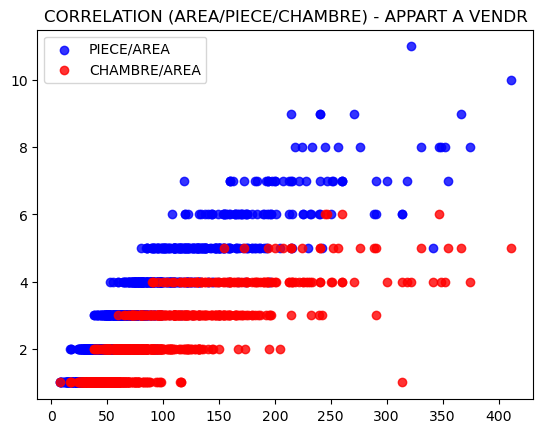

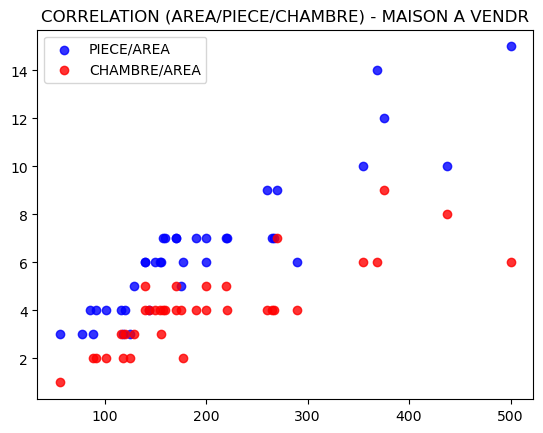

In [1288]:
import matplotlib.pyplot as plt
def corrlt_by_type(df,p_types):
    for p_type in p_types :
        df_type = df.loc[df["TYPE"] == p_type]
        plt.figure()
        plt.scatter(df_type.loc[df_type["PIECE"].notna(),"AREA"].tolist(),
                    df_type.loc[df_type["PIECE"].notna(),"PIECE"].tolist(),
                    color="blue",label="PIECE/AREA",alpha=0.8
                    )
        plt.scatter(df_type.loc[df_type["CHAMBRE"].notna(),"AREA"].tolist(),
                    df_type.loc[df_type["CHAMBRE"].notna(),"CHAMBRE"].tolist(),
                    color="red",label="CHAMBRE/AREA",alpha=0.8
                    )
        plt.legend()
        plt.title(f"CORRELATION (AREA/PIECE/CHAMBRE) - {p_type}")
        plt.savefig(f"_{p_type}_correlation_scatters.png")
        plt.show()

corrlt_by_type(test_df,["APPART A VENDR","MAISON A VENDR"])

In [1337]:
"""
        APPART A VENDR
        STUDIO A VENDR
        DUPLEX A VENDR
        LOFT A VENDR
        MAISON A VENDR
        MAISON VILL A VENDR
        VILL A VENDR
        HOTEL PARTICULI A VENDR
        PROPRIET A VENDR
        TERRAIN CONSTRUCTIBL A VENDR

        we are going to drop all that's not in this list of type
"""
valid_types = {
        "APPART A VENDR",
        "STUDIO A VENDR",
        "DUPLEX A VENDR",
        "LOFT A VENDR",
        "MAISON A VENDR",
        "MAISON VILL A VENDR",
        "VILL A VENDR",
        "HOTEL PARTICULI A VENDR",
        "PROPRIET A VENDR",
        "TERRAIN CONSTRUCTIBL A VENDR"
}
predict_types = valid_types
predict_types.discard("TERRAIN CONSTRUCTIBL A VENDR")

In [1305]:
#create and train models on maison a vendre and appart a vendre data separated.
lin_mdls = {}
lin_mtrcs = {}
lin_mdls["MAISON A VENDR"],lin_mtrcs["MAISON A VENDR"] = train_and_evaluate_option_b(test_df.dropna().loc[test_df["TYPE"] == "MAISON A VENDR"])
lin_mdls["APPART A VENDR"],lin_mtrcs["APPART A VENDR"] = train_and_evaluate_option_b(test_df.dropna().loc[test_df["TYPE"] == "APPART A VENDR"])
lin_mdls["ALL TYPES"],lin_mtrcs["ALL TYPES"] = train_and_evaluate_option_b(test_df.dropna())
lin_mtrcs

{'MAISON A VENDR': {'PIECE_from_AREA': {'MAE': 0.9575801338070448,
   'R2': 0.8622985628683155,
   'pct_exact': 0.25,
   'pct_within_1': 0.75},
  'CHAMBRE_from_AREA (direct)': {'MAE': 1.09499039322905,
   'R2': 0.44042236002324353,
   'pct_exact': 0.25,
   'pct_within_1': 0.625},
  'CHAMBRE_from_(AREA,PIECE) (true piece)': {'MAE': 1.0782410290034585,
   'R2': 0.4418204484253869,
   'pct_exact': 0.5,
   'pct_within_1': 0.625},
  'CHAMBRE_chained (AREA→PIECÊ→CHAMBRE)': {'MAE': 1.09499039322905,
   'R2': 0.44042236002324386,
   'pct_exact': 0.25,
   'pct_within_1': 0.625}},
 'APPART A VENDR': {'PIECE_from_AREA': {'MAE': 0.5812140053232058,
   'R2': 0.7794865227114635,
   'pct_exact': 0.47685185185185186,
   'pct_within_1': 0.9490740740740741},
  'CHAMBRE_from_AREA (direct)': {'MAE': 0.5316530174755463,
   'R2': 0.6456790589616441,
   'pct_exact': 0.5648148148148148,
   'pct_within_1': 0.9629629629629629},
  'CHAMBRE_from_(AREA,PIECE) (true piece)': {'MAE': 0.352790216681636,
   'R2': 0.8

In [1347]:
preds = predict_from_area(models=lin_mdls["ALL TYPES"],area_value=75.5)
preds 

{'piece_hat': 3.211826161582249,
 'piece_hat_round': 3,
 'chambre_direct': 1.8504913423484914,
 'chambre_direct_round': 2,
 'chambre_chained': 1.8504913423484917,
 'chambre_chained_round': 2}

In [1388]:
"""
preds_1 for rows that have both piece and chambre values missing
"""
def lin_predict(df,models):
    preds = {}
    mask_both_missing = df["PIECE"].isna() & df["CHAMBRE"].isna()
    mask_piece_missing = df["PIECE"].isna() & df["CHAMBRE"].notna()
    mask_chambre_missing = df["CHAMBRE"].isna() & df["PIECE"].notna()

    out = df.copy(deep=True)
    if mask_chambre_missing.any():
        X1 = out.loc[mask_chambre_missing,["AREA","PIECE"]].astype(float)
        out.loc[mask_chambre_missing, "CHAMBRE"]=np.round(
            np.maximum(0.0,np.minimum(
                X1["PIECE"].to_numpy(),
                models["chambre_from_area_piece"].predict(X1).astype(float)
                )
            )
        ).astype(int)

    if mask_both_missing.any():
        preds_by_area = out.loc[mask_both_missing,"AREA"].apply(lambda x : 
                                                                predict_from_area(models=models,area_value=float(x))
                                                               )
        out.loc[mask_both_missing,"PIECE"] = preds_by_area.apply(lambda x:x["piece_hat_round"] if isinstance(x,dict) else 0)
        out.loc[mask_both_missing,"CHAMBRE"] = preds_by_area.apply(lambda x:x["chambre_chained_round"] if isinstance(x,dict) else 0)

    if mask_piece_missing.any():
        out.loc[mask_piece_missing,"PIECE"] = out.loc[mask_piece_missing,"CHAMBRE"].astype(float) + 1         

    return out

p_rlsts = lin_predict(df =test_df,models=lin_mdls["ALL TYPES"])

In [1355]:
print(lin_mdls["ALL TYPES"])

{'piece_from_area': Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  ['AREA'])])),
                ('reg', Ridge())]), 'chambre_from_area': Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                       

In [1492]:
p_rlsts.loc[p_rlsts["TYPE"]=="TERRAIN CONSTRUCTIBL A VENDR","RAW"].iloc[0]

'Terrain constructible à vendre - Montreuil - 450\u202f000\xa0€ - 394 m² de terrain'

In [1390]:
p_rlsts.isna().sum()

RAW                  0
TAG                  0
PRICE                0
PRICE_UNIT           0
TYPE                 0
SEQ                  0
LOC                  0
ALL AREA             0
AREA                 0
TERRAIN              0
DISPONIBL MAINTEN    0
NEUF                 0
CHAMBRE              0
PIECE                0
FLOOR                0
FLOORS               0
dtype: int64

In [1274]:
mask_valid_types = test_df["TYPE"].apply(lambda x : x in valid_types if isinstance(x,str) else False)
#test_df = p_rlsts.copy(deep=True)
test_df = test_df.loc[mask_valid_type]

In [1276]:
#verify no extra elements that's not in valid types
sorted(set(test_df["TYPE"].tolist() + list(valid_types))) == sorted(valid_types)

True

In [1498]:
set(p_rlsts["TYPE"].tolist())

{'APPART A VENDR',
 'DUPLEX A VENDR',
 'HOTEL PARTICULI A VENDR',
 'LOFT A VENDR',
 'MAISON A VENDR',
 'MAISON VILL A VENDR',
 'STUDIO A VENDR',
 'TERRAIN CONSTRUCTIBL A VENDR',
 'VILL A VENDR'}

In [1505]:
p_rlsts.loc[p_rlsts["TYPE"]=="TERRAIN CONSTRUCTIBL A VENDR","TAG"].iloc[0]

['TERRAIN CONSTRUCTIBL A VENDR', 'MONTREUIL', '394 M² TERRAIN']

In [1386]:
test_df.isna().sum()

RAW                    0
TAG                    0
PRICE                  0
PRICE_UNIT             0
TYPE                   0
SEQ                    0
LOC                    0
ALL AREA               0
AREA                   0
TERRAIN                0
DISPONIBL MAINTEN      0
NEUF                   0
CHAMBRE              194
PIECE                  3
FLOOR                  0
FLOORS                 0
dtype: int64

In [1486]:
set(p_rlsts["SEQ"].explode().tolist())

{'APPART A VENDR',
 'AUBERVILLI',
 'BAGNOLET',
 'BOULOGN BILLANCOURT',
 'CHAMBR',
 'CHARENTON PONT',
 'CLICHY',
 'CLICHY GAREN',
 'DISPONIBL MAINTEN',
 'DUPLEX A VENDR',
 'ETAG',
 'HOTEL PARTICULI A VENDR',
 'ISSY MOULINEAU',
 'LE LIL',
 'LEVALLOIS PERRET',
 'LOFT A VENDR',
 'MAISON A VENDR',
 'MAISON VILL A VENDR',
 'MONTREUIL',
 'MONTROUG',
 'M²',
 'NEUF',
 'NEUILLY SEIN',
 'PANTIN',
 'PARIS',
 'PIEC',
 'PUTEAU',
 'RDC',
 'SAINT CLOUD',
 'SAINT DEN',
 'SAINT OUEN SEIN',
 'STUDIO A VENDR',
 'SURESN',
 'TERRAIN',
 'VANV',
 'VILL A VENDR'}

In [1139]:
def vectorize_dataset()

,AREA,CHAMBRE,PIECE
168,75.0,1,3
263,75.0,2,4
349,75.0,2,3
548,75.0,2,4
558,75.0,1,3
704,75.0,2,4
735,75.0,2,4
1006,75.0,2,3
1363,75.0,2,3
